<img style="float:left" width="70%" src="../../documentacion/imagenes/escudo_COLOR_1L_DCHA.png">
<img style="float:right" width="10%" src="../../documentacion/imagenes/PythonLogo.svg">
<br style="clear:both;">


<h2 style="display: inline-block; padding: 4mm; padding-left: 2em; background-color: navy; line-height: 1.3em; color: white; border-radius: 10px;">8.3. Deep Learning LSTM</h2>


 
## Estudiante:

- Jose Luis Perez Gomez

In [221]:
%run 3.Importaciones.ipynb
%run 4.Variables_Clases.ipynb

In [222]:
datosEEG_seg1_standarizado = pd.read_csv('../datos/csv/seg1_stscaler.csv', sep=',')
datosEEG_seg2_standarizado = pd.read_csv('../datos/csv/seg2_stscaler.csv', sep=',')
datosEEG_seg3_standarizado = pd.read_csv('../datos/csv/seg3_stscaler.csv', sep=',')
datosEEG_seg4_standarizado = pd.read_csv('../datos/csv/seg4_stscaler.csv', sep=',')
nombre_clases = valores_key(datosEEG_seg1_standarizado)


In [223]:
# voy a dividir los datos en:

# Train: Segmento 3 y 4
# Validate: Segmento 2
# Test: Segmento 1

In [224]:
datosEEG_train = dataframes_sin_outliers_all = pd.concat([datosEEG_seg3_standarizado, datosEEG_seg4_standarizado], axis=0)
datosEEG_val = datosEEG_seg2_standarizado
datosEEG_test = datosEEG_seg1_standarizado

In [225]:

y_train = datosEEG_train['Key'].values
X_train = datosEEG_train.drop(columns=['Key']).values

y_val = datosEEG_val['Key'].values
X_val = datosEEG_val.drop(columns=['Key']).values

y_test = datosEEG_test['Key'].values
X_test = datosEEG_test.drop(columns=['Key']).values


X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))



# LSTM (Long short-term memory)

In [226]:
# Definir parámetros
timesteps = X_train.shape[1]
features = X_train.shape[2]
num_classes = len(np.unique(y_train))

model_lstm = Sequential([
    LSTM(units=30, input_shape=(timesteps, features), return_sequences=True),
    Dropout(0.3),
    LSTM(units=30),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Learning rate personalizado
learning_rate = 0.0005  # Puedes ajustar este valor

# Definir el optimizador con el learning rate personalizado
optimizer = Adam(learning_rate=learning_rate)


model_lstm.compile(optimizer= optimizer, metrics=['accuracy'], loss='sparse_categorical_crossentropy')



C:\Users\Casa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [227]:
# Definir callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_rl = ReduceLROnPlateau(patience=5)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

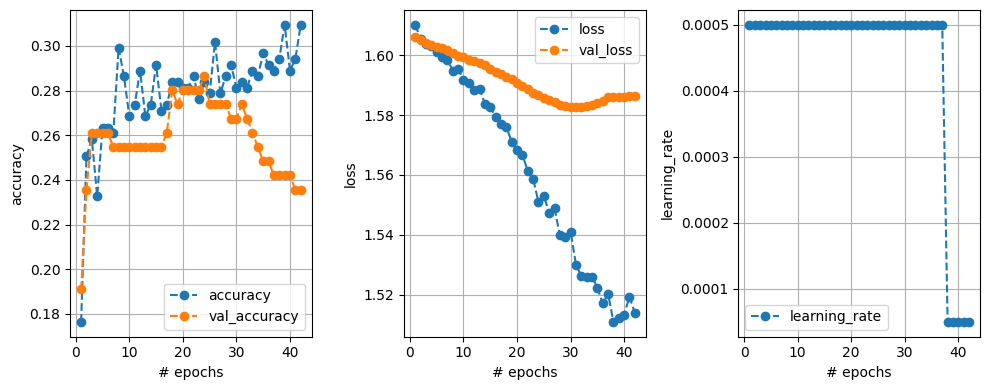

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3130 - loss: 1.4988 - val_accuracy: 0.2357 - val_loss: 1.5863 - learning_rate: 5.0000e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


In [228]:

# Entrenar el modelo
model_lstm_trained = model_lstm.fit(X_train, y_train, epochs=50, batch_size=30, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_rl, model_checkpoint, plot_learning])

#model_lstm_trained = model_lstm.fit(X_train, y_train, epochs=50, batch_size=30, validation_data= (X_val, y_val), callbacks=[early_stopping, plot_learning, timer_callback, reduce_rl, model_checkpoint])
#model_lstm_trained = model_lstm.fit(X_train, y_train, epochs=30, batch_size=1, validation_data= (X_val, y_val), callbacks=[plot_learning])

y_pred = model_lstm.predict(X_val)

y_pred_classes = np.argmax(y_pred, axis=1)


accuracy_score_lstm = accuracy_score(y_val, y_pred_classes)
matriz_confusion_lstm = confusion_matrix(y_val, y_pred_classes)

total_simple_lstm_trained = model_lstm_trained



,LSTM
Experimento_X,0.267516


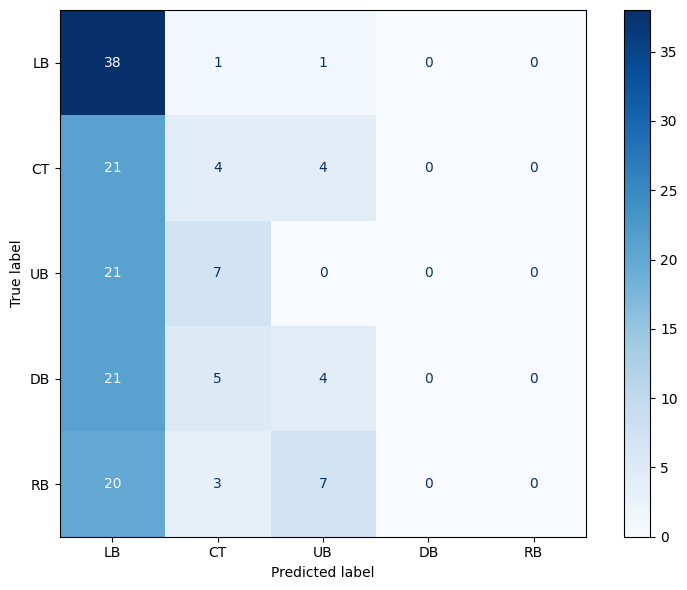

In [229]:
datos_lstm = pd.DataFrame(accuracy_score_lstm, columns=['LSTM'], index=['Experimento_X'])

display(datos_lstm)


# Crea el DataFrame de la matriz de confusión
mc_lstm = pd.DataFrame(matriz_confusion_lstm, index=nombre_clases, columns=nombre_clases)

# Configura la figura
fig, ax = plt.subplots(figsize=(8, 6))

# Crea la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=mc_lstm.values, display_labels=nombre_clases)
disp.plot(ax=ax, colorbar=True, cmap='Blues')

# Añade el título (usando el primer título de titulos_all)
#ax.set_title(titulos_all[0])

# Ajusta el espaciado y muestra la gráfica
plt.tight_layout()
plt.show()


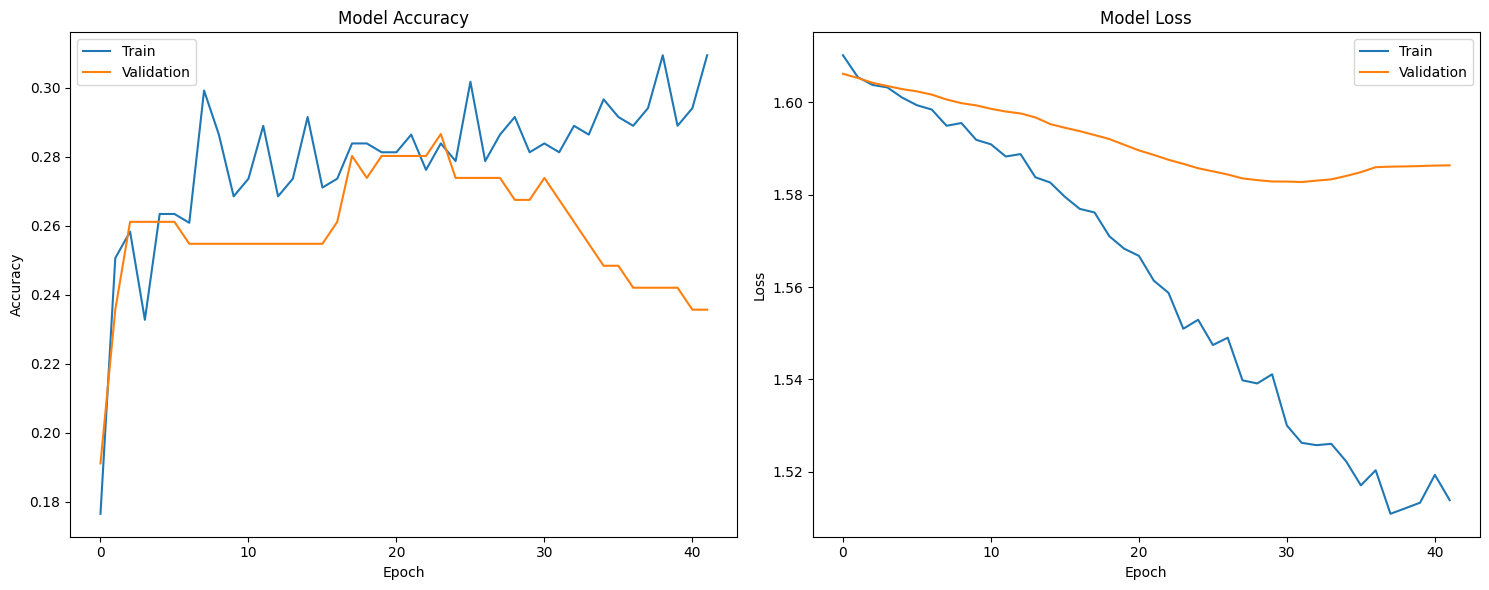

In [230]:

# Función para imprimir la gráfica
def print_chart(ax, titulo_grafica, x_eje, y_eje, datos_lineas, titulos_lineas):
    for linea in datos_lineas:
        ax.plot(linea)
    ax.set_title(titulo_grafica)
    ax.set_xlabel(x_eje)
    ax.set_ylabel(y_eje)
    ax.legend(titulos_lineas, loc='best')

# Crear una figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Imprimir la gráfica de precisión (accuracy) en el primer subgráfico
print_chart(axes[0], "Model Accuracy", "Epoch", "Accuracy", 
            [model_lstm_trained.history['accuracy'], model_lstm_trained.history['val_accuracy']], ['Train', 'Validation'])

# Imprimir la gráfica de pérdida (loss) en el segundo subgráfico
print_chart(axes[1], "Model Loss", "Epoch", "Loss", 
            [model_lstm_trained.history['loss'], model_lstm_trained.history['val_loss']], ['Train', 'Validation'])

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar las gráficas
plt.show()

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.2271 - loss: 5.6972 - val_accuracy: 0.2332 - val_loss: 5.2407 - learning_rate: 0.0010
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2121 - loss: 5.1164 - val_accuracy: 0.2694 - val_loss: 4.7069 - learning_rate: 0.0010
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2707 - loss: 4.5952 - val_accuracy: 0.2746 - val_loss: 4.2350 - learning_rate: 0.0010
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2603 - loss: 4.1367 - val_accuracy: 0.2746 - val_loss: 3.8223 - learning_rate: 0.0010
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2982 - loss: 3.7355 - val_accuracy: 0.2746 - val_loss: 3.4642 - learning_rate: 0.0010
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2670 - loss: 3.3915 - val_accuracy: 0.2746 - val_loss: 3.1560 - learning_rate: 0.0010
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2575 - loss: 3.0939 - val_accuracy:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2663 - loss: 1.5963 - val_accuracy: 0.2746 - val_loss: 1.5944 - learning_rate: 0.0010
Epoch 46/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2772 - loss: 1.5923 - val_accuracy: 0.2746 - val_loss: 1.5943 - learning_rate: 0.0010
Epoch 47/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2637 - loss: 1.5979 - val_accuracy: 0.2746 - val_loss: 1.5943 - learning_rate: 0.0010
Epoch 48/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2876 - loss: 1.5854 - val_accuracy: 0.2746 - val_loss: 1.5941 - learning_rate: 0.0010
Epoch 49/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2753 - loss: 1.5925 - val_accuracy: 0.2746 - val_loss: 1.5939 - learning_rate: 0.0010
Epoch 50/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3140 - loss: 1.5756 - val_accuracy: 0.2746 - val_loss: 1.5939 - learning_rate: 0.0010
Epoch 51/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2809 - loss: 1.5897 - val_accuracy: 0.2746

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3082 - loss: 1.5622 - val_accuracy: 0.3005 - val_loss: 1.5629 - learning_rate: 0.0010
Epoch 90/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3147 - loss: 1.5647 - val_accuracy: 0.3005 - val_loss: 1.5620 - learning_rate: 0.0010
Epoch 91/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2983 - loss: 1.5581 - val_accuracy: 0.3057 - val_loss: 1.5605 - learning_rate: 0.0010
Epoch 92/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3068 - loss: 1.5718 - val_accuracy: 0.3212 - val_loss: 1.5596 - learning_rate: 0.0010
Epoch 93/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2971 - loss: 1.5793 - val_accuracy: 0.3161 - val_loss: 1.5585 - learning_rate: 0.0010
Epoch 94/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2983 - loss: 1.5673 - val_accuracy: 0.3212 - val_loss: 1.5569 - learning_rate: 0.0010
Epoch 95/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3233 - loss: 1.5573 - val_accuracy: 0.3212

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3423 - loss: 1.5357 - val_accuracy: 0.3368 - val_loss: 1.5304 - learning_rate: 0.0010
Epoch 134/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3059 - loss: 1.5421 - val_accuracy: 0.3472 - val_loss: 1.5298 - learning_rate: 0.0010
Epoch 135/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2992 - loss: 1.5458 - val_accuracy: 0.3472 - val_loss: 1.5292 - learning_rate: 0.0010
Epoch 136/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3353 - loss: 1.5401 - val_accuracy: 0.3472 - val_loss: 1.5287 - learning_rate: 0.0010
Epoch 137/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3140 - loss: 1.5529 - val_accuracy: 0.3472 - val_loss: 1.5287 - learning_rate: 0.0010
Epoch 138/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3193 - loss: 1.5454 - val_accuracy: 0.3575 - val_loss: 1.5281 - learning_rate: 0.0010
Epoch 139/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3261 - loss: 1.5584 - val_accuracy: 

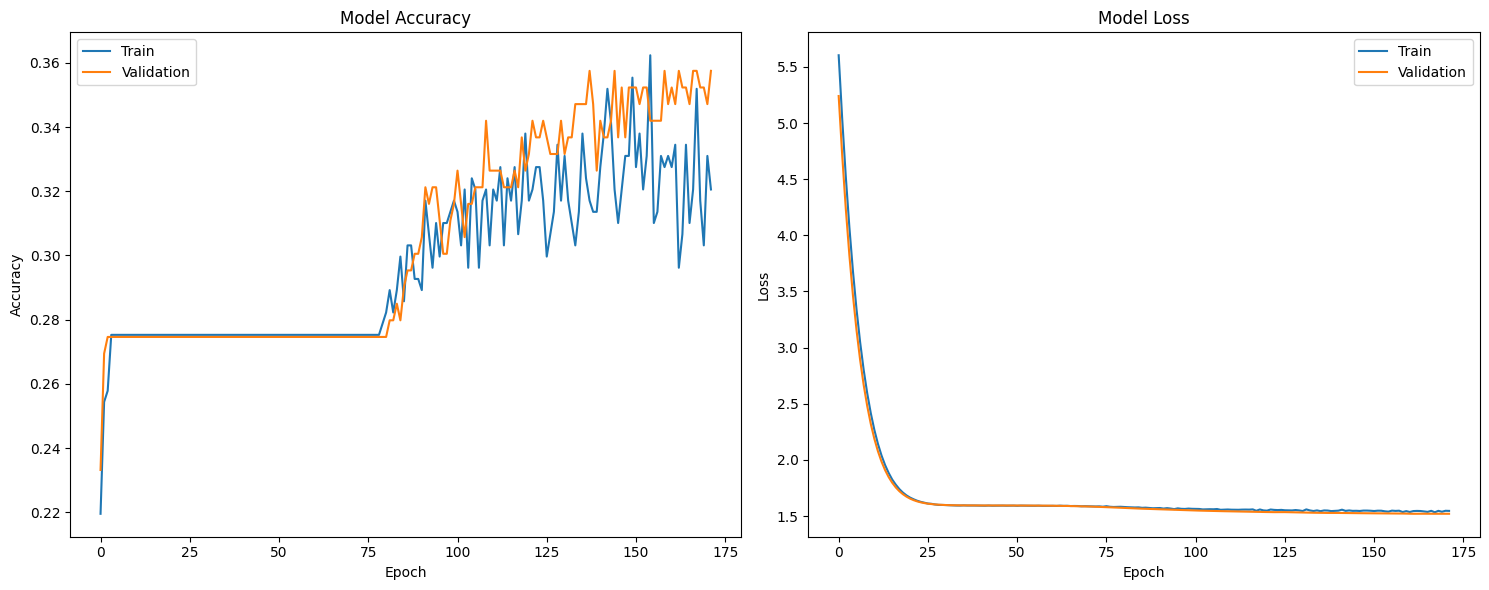

In [231]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd


datosEEG_train = dataframes_sin_outliers_all = pd.concat([datosEEG_seg1_standarizado, datosEEG_seg2_standarizado], axis=0)
datosEEG_val = datosEEG_seg3_standarizado
datosEEG_test = datosEEG_seg4_standarizado



# Preparar los datos
X_train = datosEEG_train.drop(columns=['Key']).values
y_train = datosEEG_train['Key'].values

X_val = datosEEG_val.drop(columns=['Key']).values
y_val = datosEEG_val['Key'].values

X_test = datosEEG_test.drop(columns=['Key']).values
y_test = datosEEG_test['Key'].values

# Normalizar los datos
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Redimensionar los datos
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Verificar el balance de clases
#print("Train class distribution:")
#print(pd.Series(y_train).value_counts())

#print("Validation class distribution:")
#print(pd.Series(y_val).value_counts())

#print("Test class distribution:")
#print(pd.Series(y_test).value_counts())

# Definir el modelo con menos unidades y más regularización
def build_model(timesteps, features, num_classes):
    model = Sequential([
        Input(shape=(timesteps, features)),  # Usar Input para definir la forma de entrada
        LSTM(units=120, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        Dropout(0.3),
        LSTM(units=120, kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
    return model

# Definir parámetros
timesteps = X_train_scaled.shape[1]
features = X_train_scaled.shape[2]
num_classes = len(np.unique(y_train))

# Construir el modelo
model = build_model(timesteps, features, num_classes)

# Definir callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_rl = ReduceLROnPlateau(patience=5)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Entrenar el modelo
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=60, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping, reduce_rl, model_checkpoint])

# Evaluar el modelo en los datos de prueba
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la precisión y la matriz de confusión
accuracy_score_lstm = accuracy_score(y_test, y_pred_classes)
matriz_confusion_lstm = confusion_matrix(y_test, y_pred_classes)

print(f'Accuracy: {accuracy_score_lstm}')
print(f'Confusion Matrix:\n{matriz_confusion_lstm}')

# Función para imprimir la gráfica
def print_chart(ax, titulo_grafica, x_eje, y_eje, datos_lineas, titulos_lineas):
    for linea in datos_lineas:
        ax.plot(linea)
    ax.set_title(titulo_grafica)
    ax.set_xlabel(x_eje)
    ax.set_ylabel(y_eje)
    ax.legend(titulos_lineas, loc='best')

# Crear una figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Imprimir la gráfica de precisión (accuracy) en el primer subgráfico
print_chart(axes[0], "Model Accuracy", "Epoch", "Accuracy", 
            [history.history['accuracy'], history.history['val_accuracy']], ['Train', 'Validation'])

# Imprimir la gráfica de pérdida (loss) en el segundo subgráfico
print_chart(axes[1], "Model Loss", "Epoch", "Loss", 
            [history.history['loss'], history.history['val_loss']], ['Train', 'Validation'])

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar las gráficas
plt.show()
